# Home Price Index
Find trends in HPI over time

References:
- https://old.reddit.com/r/REBubble/comments/1gpmwkv/home_prices_an_informed_perspective/
- https://fred.stlouisfed.org/series/CSUSHPINSA
- https://fred.stlouisfed.org/series/MSPNHSUS
- https://www.omnicalculator.com/finance/appreciation
- https://fred.stlouisfed.org/series/LXXRSA

In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from datetime import date


In [2]:
# load data
hpi = pd.read_csv("hpi.csv")
hpi.head()

,DATE,CSUSHPINSA,MSPNHSUS
0,1/1/1987,63.734,98500
1,2/1/1987,64.133,95200
2,3/1/1987,64.468,98400
3,4/1/1987,64.971,96500
4,5/1/1987,65.545,104900


In [3]:
#for column DATE convert string to date
hpi['DATE'] = pd.to_datetime(hpi['DATE'])
hpi['DATE'] = hpi['DATE'].dt.date
# convert date to months
hpi['TIME'] = np.arange(len(hpi)) + 1
hpi.dtypes

DATE           object
CSUSHPINSA    float64
MSPNHSUS        int64
TIME            int32
dtype: object

In [4]:
# set columns to the same scale from 1-10
columns = ['CSUSHPINSA', 'MSPNHSUS']
scalers = {}
hpi_scaled = hpi.copy()
for col in columns:
    scaler = MinMaxScaler([1, 10])
    scaler.fit(hpi[col].values.reshape(-1, 1))
    hpi_scaled[col] = scaler.transform(hpi[col].values.reshape(-1, 1))
    scalers[col] = scaler
hpi_scaled.head()

,DATE,CSUSHPINSA,MSPNHSUS,TIME
0,1987-01-01,1.000000,1.081348,1
1,1987-02-01,1.013720,1.000000,2
2,1987-03-01,1.025240,1.078882,3
3,1987-04-01,1.042537,1.032046,4
4,1987-05-01,1.062275,1.239113,5


In [ ]:
# for each date, fit an exponential model from the date to the end and find an early date that has a good fit
# y = a + b * x
# save the model parameters and score in the dataframe

# exponential growth
# v = v0 * (1 + r)^t
# log(v) = log(v0) + t * log(1 + r)
# b = log(1 + r)


for col in columns:
    hpi_scaled[col + '_model'] = [[] for i in range(len(hpi_scaled))]
    hpi_scaled[col + '_score'] = [np.nan for i in range(len(hpi_scaled))]

for i in range(3, len(hpi_scaled)-3):
    x = hpi_scaled['TIME'][i:]
    for col in columns:
        y = np.log(hpi_scaled[col][i:])
        model = np.polyfit(x, y, 1)
        hpi_scaled.at[i, col + '_model'] = model
        # calculate r2 score
        y_pred = np.polyval(model, x)
        hpi_scaled.at[i, col + '_score'] = r2_score(y, y_pred)

hpi_scaled.head()

,DATE,CSUSHPINSA,MSPNHSUS,TIME,CSUSHPINSA_model,CSUSHPINSA_score,MSPNHSUS_model,MSPNHSUS_score
0,1987-01-01,1.000000,1.081348,1,[],NaN,[],NaN
1,1987-02-01,1.013720,1.000000,2,[],NaN,[],NaN
2,1987-03-01,1.025240,1.078882,3,[],NaN,[],NaN
3,1987-04-01,1.042537,1.032046,4,"[0.004546041868940427, 0.1335736827731874]",0.924618,"[0.004318619145246925, 0.2946787063180301]",0.968451
4,1987-05-01,1.062275,1.239113,5,"[0.004542743061926435, 0.13457322129842744]",0.924116,"[0.004310217601357352, 0.29722437411657116]",0.968660


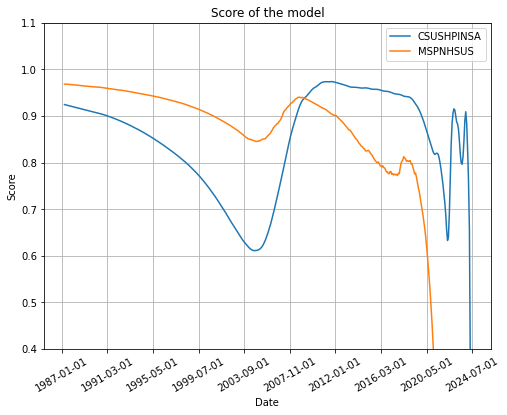

In [6]:
#plot the scores
plt.figure(figsize=(8,6))
plt.plot(hpi_scaled['DATE'], hpi_scaled['CSUSHPINSA_score'])
plt.plot(hpi_scaled['DATE'], hpi_scaled['MSPNHSUS_score'])
plt.title('Score of the model')
plt.xlabel('Date')
plt.ylabel('Score')
# give more spacing on the x-axis 
plt.xticks(hpi_scaled['DATE'][::50], rotation = 30)
plt.legend(['CSUSHPINSA', 'MSPNHSUS'])
plt.ylim(0.4, 1.1)
plt.grid()
plt.show()

In [14]:
#filter data
start_date = date(1995, 1, 1)
data = hpi[hpi['DATE'] >= start_date]

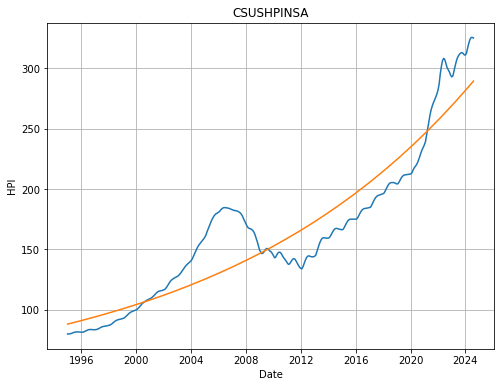

0.0044040895195200935


In [24]:
def plot_model(data, hpi_scaled, col):
    # get unscaled predictions
    model = hpi_scaled[hpi_scaled['DATE'] == start_date][f'{col}_model'].values[0]
    # log y = a + b * x
    y_pred_scaled = np.exp(np.polyval(model, data['TIME']))
    y_pred = scalers[col].inverse_transform(y_pred_scaled.reshape(-1, 1))
    # plot the data against the model
    plt.figure(figsize=(8,6))
    plt.plot(data['DATE'], data[col])
    plt.plot(data['DATE'], y_pred)
    plt.title(col)
    plt.xlabel('Date')
    plt.ylabel('HPI')
    plt.grid()
    plt.show()

    return model

model = plot_model(data, hpi_scaled, 'CSUSHPINSA')
print(np.exp(model[0]) - 1)

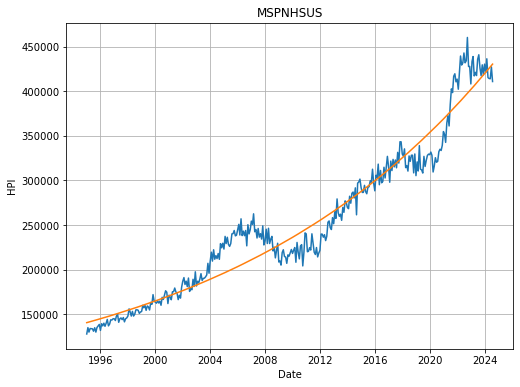

0.004163722312145346


In [25]:
model = plot_model(data, hpi_scaled, 'MSPNHSUS')
print(np.exp(model[0]) - 1)

In [26]:
# annual appreciation rate ~ 1.04

# b = log(1 + r)
r = np.exp(model[0]) - 1
#unscaled r
r = scalers['MSPNHSUS'].inverse_transform([[r]])[0][0]
print(r)

# np.exp(model[1])

54802.24166846271
